In [1]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES']='2'
%matplotlib inline

/home/lhw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/lhw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#数据读取
train_file_path = './data/training.csv'
test_file_path = './data/test.csv'

train_pd = pd.read_csv(train_file_path)
test_pd = pd.read_csv(test_file_path)
#去除含空值的行
train_pd.dropna(axis=0, how='any', inplace=True)
print(train_pd.shape)

(2140, 31)


In [3]:
from joblib import Parallel, delayed
def format_img(x):
    return np.asarray([int(e) for e in x.split(' ')], dtype=np.uint8).reshape(96, 96)
#并行处理，将图片抽取出来
with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    train_img = ex(delayed(format_img)(e) for e in train_pd.Image)
with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    test_img = ex(delayed(format_img)(e) for e in test_pd.Image)
train_img = np.stack(train_img)[..., None]
test_img = np.stack(test_img)[..., None]
print(train_img.shape, test_img.shape)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:   11.5s
[Parallel(n_jobs=10)]: Done 2140 out of 2140 | elapsed:   13.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    8.3s


(2140, 96, 96, 1) (1783, 96, 96, 1)


[Parallel(n_jobs=10)]: Done 1783 out of 1783 | elapsed:   12.0s finished


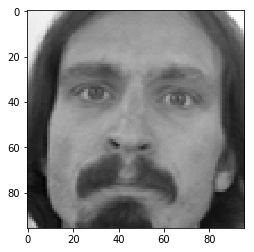

In [4]:
plt.imshow(train_img[0, :, :, 0], cmap='gray')
plt.show()

In [5]:
#获取关键点坐标
train_y = train_pd.iloc[:, :-1].values
print(train_y.shape)
print(train_y[1, :])

(2140, 30)
[64.33293617 34.9700766  29.9492766  33.44871489 58.85617021 35.27434894
 70.7227234  36.18716596 36.0347234  34.36153191 24.47251064 33.14444255
 53.98740426 28.27594894 78.63421277 30.4059234  42.72885106 26.14604255
 16.8653617  27.05885957 48.20629787 55.66093617 56.42144681 76.352
 35.12238298 76.04765957 46.68459574 70.26655319 45.46791489 85.48017021]


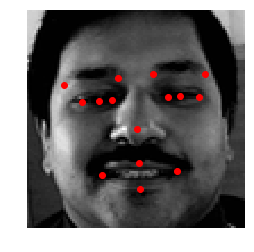

In [6]:
#将关键点和图像相融合
def show(x, y=None):
    plt.imshow(x[..., 0], 'gray')
    if y is not None:
        #np.vstack(np.split(y, 15))先切分成15组，再按组相连 
        #[1, 2, 3, 4,, 5, 6]=>[1, 2,],[3, 4], [5, 6]=>[[1,2], [3, 4], [5, 6]]
        points = np.vstack(np.split(y, 15)).T
        plt.plot(points[0], points[1], 'o', color = 'red')
    plt.axis('off')
sample_idx = np.random.choice(len(train_img))
show(train_img[sample_idx], train_y[sample_idx])

In [60]:
#数据预处理
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_img, train_y, test_size=0.2, random_state=42, shuffle=True)#random_state：是随机数的种子
print(x_train.shape, x_val.shape)
print(y_val[0].shape)

(1712, 96, 96, 1) (428, 96, 96, 1)
(30,)


In [8]:
#定义模型
def model(input, is_training):
    with tf.variable_scope('layer1'):
        conv1 = tf.layers.conv2d(input, 32, 3, strides=1, padding='VALID')
        relu1 = tf.nn.relu(conv1)
        norm1 = tf.layers.batch_normalization(relu1, center=True, scale=True, training=True)
        pool1 = tf.layers.max_pooling2d(norm1, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer2'):
        conv2 = tf.layers.conv2d(pool1, 64, 2, strides=1, padding='VALID')
        relu2= tf.nn.relu(conv2)
        norm2 = tf.layers.batch_normalization(relu2, center=True, scale=True, training=True)
        pool2 = tf.layers.max_pooling2d(norm2, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer3'):
        conv3 = tf.layers.conv2d(pool2, 128, 2, strides=1, padding='VALID')
        relu3 = tf.nn.relu(conv3)
        norm3 = tf.layers.batch_normalization(relu3, center=True, scale=True, training=True)
        pool3 = tf.layers.max_pooling2d(norm3, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer4'):
        flatten = tf.reshape(pool3, [-1, 11*11*128])
        layer4 = tf.layers.dense(flatten, 1024)
        relu4 = tf.nn.relu(layer4)
        if is_training == True:
            relu4 = tf.layers.dropout(relu4, 0.5)
    with tf.variable_scope('layer5'):
        layer5 = tf.layers.dense(relu4, 500)
        relu5 = tf.nn.relu(layer5)
        output = tf.layers.dense(relu5, 30)
    return output
#改网络https://github.com/saber1988/facial-keypoints-detection/blob/master/facial_keypoints_detection.py

In [ ]:
#训练

ckpt_path = './model/model.ckpt'
tf.reset_default_graph()
x_data = tf.placeholder(tf.float32, [None, 96, 96, 1])
y_data = tf.placeholder(tf.float32, [None, 30])
is_training = tf.placeholder(tf.bool)

out = model(x_data, is_training)
#损失函数 rsme
rmse = tf.sqrt(tf.reduce_mean(tf.square(y_data - out)))
train_step = tf.train.AdadeltaOptimizer(0.03).minimize(rmse)
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    epoch = 1000
    batch_size = 100
    num_batch = len(x_train) // batch_size
    remainder = len(x_train) % batch_size
    print("数据分 %s 批， 前面每批数据 %s 个数据， 最后一批 %s 个数据" % (num_batch, batch_size, remainder))
    for n in range(epoch):
        for i in range(num_batch):
            x_batch = x_train[i*batch_size : (i+1)*batch_size]
            y_batch = y_train[i*batch_size : (i+1)*batch_size]
            _, loss_step = sess.run([train_step, rmse], \
                             feed_dict={x_data:x_batch, y_data:y_batch, is_training:True})
        if remainder > 0:
            start_index = num_batch * batch_size
            x_batch = x_train[start_index : len(x_train)-1]
            y_batch = y_train[start_index : len(x_train)-1]
            _, loss_step = sess.run([train_step, rmse], \
                             feed_dict={x_data:x_batch, y_data:y_batch, is_training:True})
        if n % 5 == 0:
            validation_loss = rmse.eval(feed_dict={x_data:x_val, y_data:y_val, is_training:False})
            print("epoch %d train loss is %f validataion loss is %f" % (n, loss_step, validation_loss))
    saver.save(sess, ckpt_path)

数据分 17 批， 前面每批数据 100 个数据， 最后一批 12 个数据
epoch 0 train loss is 44.038021 validataion loss is 42.760979
epoch 5 train loss is 3.591942 validataion loss is 5.401104
epoch 10 train loss is 3.019749 validataion loss is 6.552473
epoch 15 train loss is 3.658161 validataion loss is 4.634448
epoch 20 train loss is 4.877209 validataion loss is 4.670528
epoch 25 train loss is 0.976023 validataion loss is 4.352732
epoch 30 train loss is 2.123931 validataion loss is 3.878322
epoch 35 train loss is 4.509325 validataion loss is 3.854559
epoch 40 train loss is 1.463909 validataion loss is 3.737035
epoch 45 train loss is 1.798071 validataion loss is 3.556609
epoch 50 train loss is 4.078311 validataion loss is 3.484539
epoch 55 train loss is 1.580215 validataion loss is 3.343718
epoch 60 train loss is 1.781873 validataion loss is 3.289846
epoch 65 train loss is 3.710409 validataion loss is 3.271765
epoch 70 train loss is 1.460488 validataion loss is 3.144192
epoch 75 train loss is 1.677451 validataion los

epoch 660 train loss is 0.520184 validataion loss is 2.343990
epoch 665 train loss is 0.508426 validataion loss is 2.353983
epoch 670 train loss is 0.505969 validataion loss is 2.358902
epoch 675 train loss is 0.485832 validataion loss is 2.363147
epoch 680 train loss is 0.492565 validataion loss is 2.389336
epoch 685 train loss is 0.487571 validataion loss is 2.398585
epoch 690 train loss is 0.578059 validataion loss is 2.411066
epoch 695 train loss is 0.590900 validataion loss is 2.410572
epoch 700 train loss is 0.642675 validataion loss is 2.398098
epoch 705 train loss is 0.650015 validataion loss is 2.399497
epoch 710 train loss is 0.600996 validataion loss is 2.393019
epoch 715 train loss is 0.578786 validataion loss is 2.376739
epoch 720 train loss is 0.592130 validataion loss is 2.375489
epoch 725 train loss is 0.612057 validataion loss is 2.348378
epoch 730 train loss is 0.578768 validataion loss is 2.337444
epoch 735 train loss is 0.681567 validataion loss is 2.331347
epoch 74

In [65]:
def show_pred(x, y_real, y_pred):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for ax in axes:
        ax.imshow(x[0, ..., 0], 'gray')
        ax.axis('off')
    points_real = np.vstack(np.split(y_real[0], 15)).T 
    points_pred = np.vstack(np.split(y_pred[0], 15)).T 
    axes[0].plot(points_pred[0], points_pred[1], 'o', color='red')
    axes[0].set_title('Predictions', size=16)
    axes[1].plot(points_real[0], points_real[1], 'o', color='green')
    axes[1].plot(points_pred[0], points_pred[1], 'o', color='red', alpha=0.5)
    axes[1].set_title('Real', size=16)

INFO:tensorflow:Restoring parameters from ./model/model.ckpt


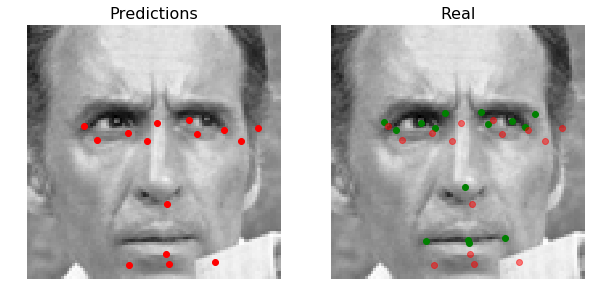

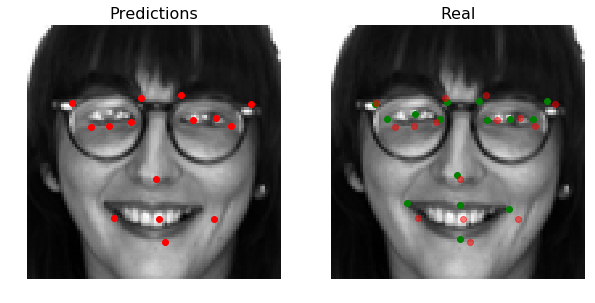

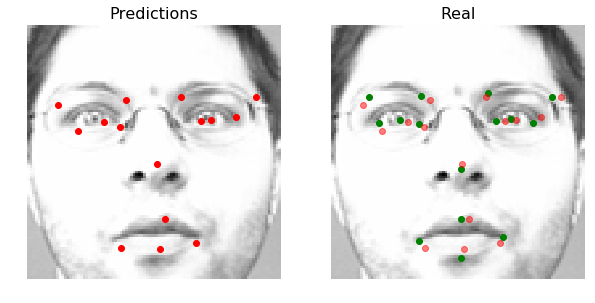

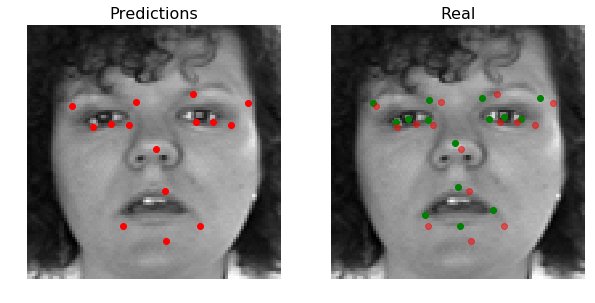

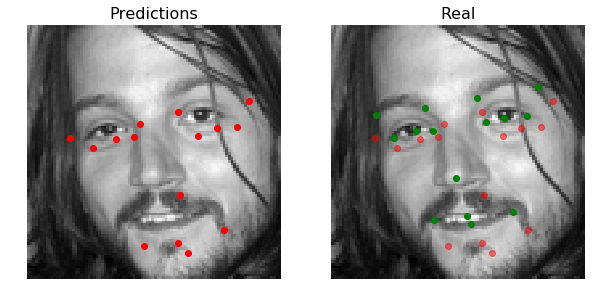

In [72]:
#测试
ckpt_path = './model/model.ckpt'
tf.reset_default_graph()
x_val_data = tf.placeholder(tf.float32, [None, 96, 96, 1])
is_training = tf.placeholder(tf.bool)
predict = model(x_val_data, is_training)
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, ckpt_path)
    for i in range(5):
        idx = np.random.choice(len(x_val))
        sample_x = x_val[idx, None]#增加一维(1, 96, 96, 1) 而x_val[0]=>( 96, 96, 1)
        sample_y = y_val[idx, None]
        #sess.run(predict, feed_dict={x_val_data:sample_x, is_training:False})
        pred = predict.eval(feed_dict={x_val_data:sample_x, is_training:False})
        show_pred(sample_x, sample_y, pred)

INFO:tensorflow:Restoring parameters from ./model/model.ckpt


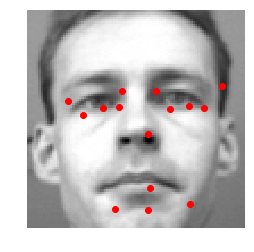

In [70]:
#测试
ckpt_path = './model/model.ckpt'
tf.reset_default_graph()
x_val_data = tf.placeholder(tf.float32, [None, 96, 96, 1])
is_training = tf.placeholder(tf.bool)
predict = model(x_val_data, is_training)
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, ckpt_path)
    sample_x = test_img[3, None]
    pred = predict.eval(feed_dict={x_val_data:sample_x, is_training:False})
    show(test_img[3], pred[0])

In [10]:
#提交结果
keypoint_index = {
    'left_eye_center_x':0,
    'left_eye_center_y':1,
    'right_eye_center_x':2,
    'right_eye_center_y':3,
    'left_eye_inner_corner_x':4,
    'left_eye_inner_corner_y':5,
    'left_eye_outer_corner_x':6,
    'left_eye_outer_corner_y':7,
    'right_eye_inner_corner_x':8,
    'right_eye_inner_corner_y':9,
    'right_eye_outer_corner_x':10,
    'right_eye_outer_corner_y':11,
    'left_eyebrow_inner_end_x':12,
    'left_eyebrow_inner_end_y':13,
    'left_eyebrow_outer_end_x':14,
    'left_eyebrow_outer_end_y':15,
    'right_eyebrow_inner_end_x':16,
    'right_eyebrow_inner_end_y':17,
    'right_eyebrow_outer_end_x':18,
    'right_eyebrow_outer_end_y':19,
    'nose_tip_x':20,
    'nose_tip_y':21,
    'mouth_left_corner_x':22,
    'mouth_left_corner_y':23,
    'mouth_right_corner_x':24,
    'mouth_right_corner_y':25,
    'mouth_center_top_lip_x':26,
    'mouth_center_top_lip_y':27,
    'mouth_center_bottom_lip_x':28,
    'mouth_center_bottom_lip_y':29
}    

In [44]:
#测试
ckpt_path = './model/model.ckpt'
tf.reset_default_graph()
x_test_data = tf.placeholder(tf.float32, [None, 96, 96, 1])
is_training = tf.placeholder(tf.bool)
predict = model(x_test_data, is_training)
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, ckpt_path)
    y_pred = []
    test_size = test_img.shape[0]
    batch_size = 1
    num_batch = test_size // batch_size
    remainder = test_size % batch_size
    print("数据分 %s 批， 前面每批数据 %s 个数据， 最后一批 %s 个数据" % (num_batch, batch_size, remainder))
    for i in range(num_batch):
        x_batch = test_img[i*batch_size : (i+1)*batch_size]
        #sess.run(predict, feed_dict={x_test_data:x_batch, is_training:False})
        y_pred_batch = predict.eval(feed_dict={x_test_data:x_batch, is_training:False})
        y_pred.append(y_pred_batch)
    if remainder > 0:
        start_idx = num_batch * batch_size
        x_batch = test_img[start_idx : test_size-1]
        y_pred_batch = predict.eval(feed_dict={x_test_data:x_batch, is_training:False})
        y_pred.append(y_pred_batch)
    print("predict test image done!")
    y_pred_np = np.array(y_pred)
    y = y_pred_np.reshape(-1, 30)
    #print(y.shape)
    output_file = open("submit.csv", 'w')
    output_file.write('RowId,location\n')
    id_lookup_table = open('data/IdLookupTable.csv')
    id_lookup_table.readline()
    for line in id_lookup_table:
        RowId,ImageId,FeatureName = line.rstrip().split(',')
        image_index = int(ImageId) - 1
        feature_index = keypoint_index[FeatureName]
        feature_location = y[image_index][feature_index]
        output_file.write('{0},{1}\n'.format(RowId,feature_location))
    output_file.close()
    id_lookup_table.close()
    print('Finish!')

INFO:tensorflow:Restoring parameters from ./model/model.ckpt
数据分 1783 批， 前面每批数据 1 个数据， 最后一批 0 个数据
predict test image done!
Finish!
